In [1]:
## Figure 14 - Comparing PySAR and GIAnT.

import os
import sys
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt, ticker
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pysar.simulation.plot import *
from pysar.objects import timeseries, ifgramStack, sensor
from pysar.utils import readfile, writefile, ptime, plot as pp, utils as ut, network as pnet
from pysar import view

work_dir = os.path.expanduser('~/development/python/2018_ComputGeosci_PySAR/pysar_vs_giant')
os.chdir(work_dir)
print('Go to directory: '+work_dir)

proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/GIANT')
proj_name = sensor.project_name2sensor_name(proj_dir)[1]

ts_files = [os.path.join(proj_dir, i) for i in ['PYSAR/timeseries_ECMWF_ramp_demErr.h5',
                                                'Stack/NSBAS-PARAMS.h5',  #same as SBAS for its pts
                                                'Stack/TS-PARAMS.h5']]
ts_files = [os.path.join(proj_dir, i) for i in ['PYSAR/WITHOUT_UNW_COR/timeseries_ECMWF_ramp_demErr.h5',
                                                'Stack/NSBAS-PARAMS.h5',  #same as SBAS for its pts
                                                'Stack/TS-PARAMS.h5']]
vel_files = [os.path.join(proj_dir, i) for i in ['PYSAR/velocity.h5',
                                                 'LS-velocity.h5',
                                                 'NSBAS-velocity.h5',
                                                 'TS-velocity.h5']]
tcoh_file = os.path.join(proj_dir, 'PYSAR/temporalCoherence.h5')
geom_file = os.path.join(proj_dir, '../PYSAR/INPUTS/geometryRadar.h5')

# Info
atr = readfile.read_attribute(ts_files[0])
coord = ut.coordinate(atr, geom_file)
date_list = timeseries(ts_files[0]).get_date_list()
dates, datevector = ptime.date_list2vector(date_list)

## Points of Interest
pts_lalo = [[-0.3706, -91.5418],    #D, Fernandina caldera, low temp coh                 --> g-nsbas/pysar give result, but pysar dropped due to low tcoh
            [-0.3637, -91.5287],    #C, Fernandina caldera, low coherent w unw err       --> g-sbas/nsbas overestimated due to unw err, g-timefun filering
            [-0.3750, -91.0781],    #B, Alcedo lava flow, low coherent w/o unw err       --> g-nsbas underestimated
            [-0.4369, -91.1162],    #A, Alcedo crater center, high coherent w/o unw err  --> all the same
           ]

#convert lalo to yx
pts_yx = []
for lat, lon in pts_lalo:
    y, x = coord.geo2radar(lat, lon)[0:2]
    pts_yx.append([y, x])
num_pts = len(pts_yx)

Go to directory: /Users/yunjunz/development/python/2018_ComputGeosci_PySAR/pysar_vs_giant


In [48]:
## prepare histogram data

# Read PYSAR
num_pysar      = readfile.read(os.path.join(proj_dir, 'PYSAR/numInvIfgram.h5'))[0].flatten()
mask_pysar_out = readfile.read(os.path.join(proj_dir, 'PYSAR/maskTempCoh.h5'))[0].flatten()
mask_pysar_in  = num_pysar != 0.
num_pysar_max = np.max(num_pysar[mask_pysar_in])

# Read GIANT
num_giant = readfile.read(os.path.join(proj_dir, 'Stack/NSBAS-PARAMS.h5'), datasetName='ifgcnt')[0].flatten()
num_giant_max = np.max(num_giant)
mask_gsbas = num_giant == num_giant_max
mask_gnsbas = num_giant != 0.
mask_gnsbas *= ~np.isnan(num_giant)
mask_gtimefun = np.array(mask_gsbas)

# summarize data
num_data = (num_pysar[mask_pysar_in],
            num_pysar[mask_pysar_out],
            num_giant[mask_gsbas],
            num_giant[mask_gnsbas],
            num_giant[mask_gtimefun])
print('Done.')

Done.


save figure to vel_GalapagosSenDT128.png


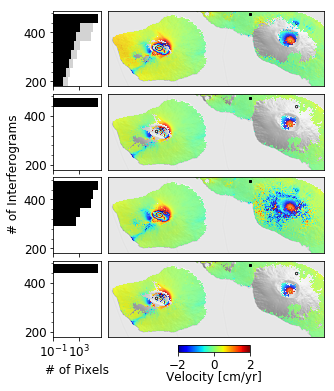

In [53]:
# Fig. 13 (a-h) Histogram and Linear Velocity Map

fig = plt.figure(figsize=(5, 6))
gs = GridSpec(4, 6, figure=fig)
axs1 = [fig.add_subplot(gs[0, 0]),
        fig.add_subplot(gs[1, 0]),
        fig.add_subplot(gs[2, 0]),
        fig.add_subplot(gs[3, 0])]
axs2 = [fig.add_subplot(gs[0, 1:]),
        fig.add_subplot(gs[1, 1:]),
        fig.add_subplot(gs[2, 1:]),
        fig.add_subplot(gs[3, 1:])]

## left - histogram
for i in range(1,len(axs1)):
    axs1[i].get_shared_x_axes().join(axs1[i], axs1[0])
    axs1[i].get_shared_y_axes().join(axs1[i], axs1[0])
min_num_ifg = 180

for i in [0,1,2,3,4]:
    if i == 0:
        ax = axs1[0]
        color = 'lightgray'
    else:
        ax = axs1[i-1]
        color = 'black'
    ax.hist(num_data[i], bins=8, histtype='stepfilled', range=(min_num_ifg, num_pysar_max), log=True, color=color, orientation='horizontal')
    #ax.invert_yaxis()

# axis format
#def millions(x, pos):
#    return '%1.0fM' % (x*1e-6)
#formatter = ticker.FuncFormatter(millions)
for ax in axs1:
    ax.tick_params(which='both', direction='out', labelsize=font_size)
    ax.set_ylim(bottom=min_num_ifg)
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(5))
    #ax.xaxis.set_major_formatter(formatter)
    #ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    if ax != axs1[-1]:
        ax.get_xaxis().set_ticklabels([])
axs1[-1].set_xlabel('# of Pixels', fontsize=font_size)
pp.set_shared_ylabel(axs1, '# of Interferograms', font_size=font_size)

## right - velocity
print_msg = False
for i in range(len(vel_files)):
    ax = axs2[i]
    cmd  = 'view.py {} velocity -d {} --dem-nocontour '.format(vel_files[i], geom_file)
    cmd += '--sub-x 400 1680 --sub-y 750 1200 '
    cmd += '-u cm --wrap --wrap-range -2 2 -c jet '
    cmd += '--notitle --notick --ref-size 2 --nocbar --fontsize 12 '
    if print_msg:
        print(cmd)
    d_v, atr, inps = view.prep_slice(cmd, print_msg=print_msg)
    ax, inps, im, cbar = view.plot_slice(ax, d_v, atr, inps, print_msg=print_msg)
fig.subplots_adjust(hspace=0.1, wspace=-0.02)

# point of interest
for i in range(len(pts_yx)):
    y, x = pts_yx[i]
    for ax in axs2:
        ax.scatter(x, y, s=2.5**2, color='none', edgecolors='k', lw=0.8)

# colorbar
cax = fig.add_axes([0.47, 0.09, 0.2, 0.015])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal', ticks=[-2, 0, 2])
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Velocity [cm/yr]', fontsize=font_size, labelpad=-1)

# save
out_file= 'vel_{}.png'.format(proj_name)
#plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('save figure to {}'.format(out_file))
plt.show()

In [ ]:
## Run to get Points of Interest @ GIANT/Stack directory
#!tsview.py ../PYSAR/timeseries_ECMWF_demErr_ramp.h5 TS-PARAMS.h5 NSBAS-PARAMS.h5 TS-PARAMS.h5 --ylim -20 40 --label pysar g-sbas g-nsbas g-timefun --wrap --wrap-range -5 5 --zf -l ../../PYSAR/INPUTS/geometryRadar.h5 --yx 825 562

dropped: [[0.49636197]]
saved to file ts_GalapagosSenDT128_noUnwCor.png


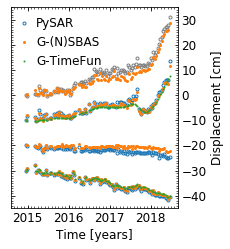

In [11]:
## Fig. 13i - Displacement time-series on pixels of interest

# setting
off = -10
unit_scales = [100., 0.1, 0.1]
ms_list = np.array([3, 2, 1])
colors = pp.mplColors[0:3]
labels = ['PySAR', 'G-(N)SBAS', 'G-TimeFun']

def plot_one_pixel(ax, box, off=0.):
    for i in range(len(ts_files)):
        dis_ts = readfile.read(ts_files[i], box=box, print_msg=False)[0] * unit_scales[i]
        dis_ts -= dis_ts[0]
        # temp coh and masking
        pts_tcoh = readfile.read(tcoh_file, box=box, print_msg=False)[0]
        if i == 0:
            pts_mec = colors[i]
            pts_mfc = 'none'
            pts_label = labels[i]
            if pts_tcoh < 0.7:
                pts_mec = 'gray'
                print('dropped: {}'.format(pts_tcoh))
        else:
            pts_mec = colors[i]
            pts_mfc = colors[i]
            pts_label = labels[i]
        ax.plot(dates, dis_ts+off, 'o', label=pts_label, ms=ms_list[i], mec=pts_mec, mfc=pts_mfc)
    return ax

# plot
fig, ax = plt.subplots(figsize=(3, 3.7))
for i in range(len(pts_yx)):
    y, x = pts_yx[i]
    ax = plot_one_pixel(ax, box=(x, y, x+1, y+1), off=off*i)

ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator(10))
pp.auto_adjust_xaxis_date(ax, datevector, fontsize=font_size)
ax.tick_params(which='both', direction='in', labelsize=font_size, bottom=True, top=True, left=True, right=True)
ax.set_ylim(-45, 35)
ax.set_xlabel('Time [years]', fontsize=font_size)
ax.set_ylabel('Displacement [cm]', fontsize=font_size)

# plot legend on a different figure
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[3:6], labels[3:6], loc=(-0.02, 0.675), fontsize=font_size, frameon=False, borderaxespad=0.1, handletextpad=0)

# save figure
if 'WITHOUT_UNW_COR' in ts_files[0]:
    out_file = 'ts_{}_noUnwCor.png'.format(proj_name)
else:
    out_file = 'ts_{}.png'.format(proj_name)
plt.savefig(out_file, bbox_inches='tight', transparent=True, dpi=fig_dpi)
print('saved to file {}'.format(out_file))
plt.show()

start/end date: 20141213/20180619


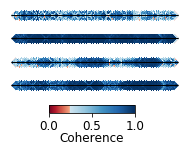

In [10]:
## Fig. 14j - coherence matrix of POIs
cmap = pp.ColormapExt('truncate_RdBu', vlist=[0, 0.25, 1]).colormap
min_date, max_date = '20161219', '20180619'

ifg_file = os.path.join(proj_dir, '../PYSAR/INPUTS/ifgramStack.h5')
stack_obj = ifgramStack(ifg_file)
stack_obj.open(print_msg=False)
# get date12_list between (min_date, max_date)
date12_list0 = stack_obj.get_date12_list(dropIfgram=False)
tempList  = [i for i in date12_list0 if any(int(j) < int(min_date) for j in i.split('_'))]
tempList += [i for i in date12_list0 if any(int(j) > int(max_date) for j in i.split('_'))]
date12_list = sorted(list(set(date12_list0) - set(tempList)))
dset_list = ['coherence-{}'.format(i) for i in date12_list]
# info
mDates = [i.split('_')[0] for i in date12_list]
sDates = [i.split('_')[1] for i in date12_list]
dateList = sorted(list(set(mDates + sDates)))
print('start/end date: {}/{}'.format(dateList[0], dateList[-1]))

# plot
fig, axs = plt.subplots(nrows=num_pts, ncols=1, figsize=[3, 3])
for i in range(num_pts):
    y, x = pts_yx[i]
    box = (x, y, x+1, y+1)
    coh = np.squeeze(readfile.read(ifg_file, datasetName=dset_list, box=box, print_msg=False)[0])
    # get date12_list_drop
    coh_date12_list = list(np.array(date12_list)[coh >= 0.25])
    date12_list_drop = [i for i in date12_list if i not in coh_date12_list]
    #plot
    ax = axs[i]
    ax, im = pp.plot_rotate_diag_coherence_matrix(ax, coh.tolist(), date12_list, date12_list_drop, cmap=cmap, disp_min=0.0)
fig.subplots_adjust(hspace=-0.75)

# plot colorbar
#fig = plt.figure(figsize=(1.5, 0.1))
cax = fig.add_axes([0.3, 0.215, 0.4, 0.035])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')

cbar.ax.tick_params(labelsize=font_size)
cbar.locator = ticker.MaxNLocator(nbins=2)
cbar.update_ticks()
cbar.set_label('Coherence', fontsize=font_size, labelpad=-1)
#cbar.ax.xaxis.tick_top()
#cbar.ax.xaxis.set_label_position('top')
#plt.savefig('pysar_vs_giant_coh_mat_cbar.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)

plt.savefig('pysar_vs_giant_coh_mat.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

open ifgramStack file: ifgramStack.h5


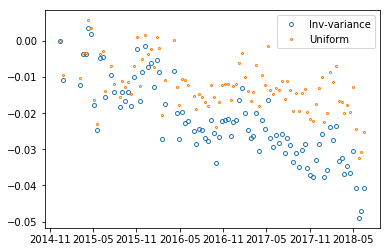

In [3]:
## Test for point B to prove: the difference in displacement time-series is due to weighting in the network inversion.
from pysar import ifgram_inversion as ifginv

proj_dir = os.path.expanduser('~/insarlab/Galapagos/GalapagosSenDT128/PYSAR')
proj_name = sensor.project_name2sensor_name(proj_dir)[1]

ifgram_file = os.path.join(proj_dir, 'INPUTS/ifgramStack.h5')
geom_file   = os.path.join(proj_dir, 'INPUTS/geometryRadar.h5')
ts_file     = os.path.join(proj_dir, 'timeseries.h5')

atr = readfile.read_attribute(ifgram_file)
coord = ut.coordinate(atr, geom_file)

lat, lon = -0.3750, -91.0781   #point B along the flank of Alcedo
y, x = coord.geo2radar(lat, lon)[0:2]
box = (x, y, x+1, y+1)

# prepare for network inversion
stack_obj = ifgramStack(ifgram_file)
stack_obj.open()
num_ifgram = stack_obj.numIfgram
date_list = stack_obj.dateList
num_date = len(date_list)
tbase = np.array(ptime.date_list2tbase(date_list)[0], np.float32) / 365.25
tbase_diff = np.diff(tbase).reshape(-1, 1)
dates = ptime.date_list2vector(date_list)[0]

L = int(stack_obj.metadata['RLOOKS']) * int(stack_obj.metadata['ALOOKS'])
phase2range = -1*float(stack_obj.metadata['WAVELENGTH'])/(4.*np.pi)
A, B = stack_obj.get_design_matrix4timeseries_estimation()[0:2]

# read interferogram data
ref_y, ref_x = int(atr['REF_Y']), int(atr['REF_X'])
ref_box = (ref_x, ref_y, ref_x+1, ref_y+1)
unw_ref = readfile.read(ifgram_file, datasetName='unwrapPhase_bridging_phaseClosure', box=ref_box)[0]
unw = readfile.read(ifgram_file, datasetName='unwrapPhase_bridging_phaseClosure', box=box)[0]
cor = readfile.read(ifgram_file, datasetName='coherence', box=box)[0]

# run network inversion
w_sqrt = np.sqrt(ifginv.coherence2weight(cor, weight_func='var', L=L, print_msg=False))
ts_var = ifginv.estimate_timeseries(A, B, tbase_diff, unw, w_sqrt)[0] * phase2range
ts_no  = ifginv.estimate_timeseries(A, B, tbase_diff, unw)[0] * phase2range

# plot
plt.figure()
plt.plot(dates, ts_var, 'o', mfc='none', ms=4, label='Inv-variance')
plt.plot(dates, ts_no, 'o', mfc='none', ms=2, label='Uniform')
plt.legend()
plt.show()

open timeseries file: timeseries_ECMWF_ramp_demErr.h5


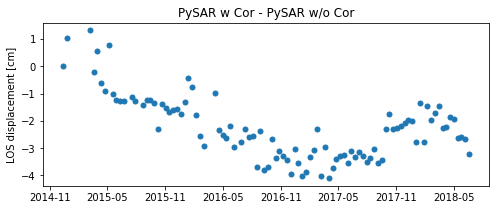

In [8]:
## test for pixel D

ts_files = [os.path.join(proj_dir, i) for i in ['PYSAR/timeseries_ECMWF_ramp_demErr.h5',
                                                'PYSAR/WO_UNW_COR/timeseries_ECMWF_ramp_demErr.h5']]
obj = timeseries(ts_files[0])
obj.open()

y, x = pts_yx[0]
box = (x, y, x+1, y+1)
dis_w  = readfile.read(ts_files[0], box=box)[0] * 100.; dis_w  -= dis_w[0]
dis_wo = readfile.read(ts_files[1], box=box)[0] * 100.; dis_wo -= dis_wo[0]

fig, ax = plt.subplots(figsize=[8, 3])
ax.plot(obj.times, dis_w - dis_wo, 'o', ms=5)
ax.set_title('PySAR w Cor - PySAR w/o Cor')
ax.set_ylabel('LOS displacement [cm]')
plt.savefig('pysar_diff_w_wo_unwCor.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()

start/end date: 20141213/20180619


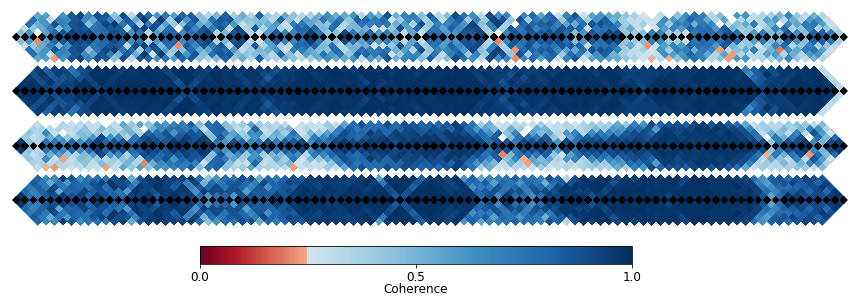

In [14]:
## Fig. 14j - coherence matrix of POIs
cmap = pp.ColormapExt('truncate_RdBu', vlist=[0, 0.25, 1]).colormap
min_date, max_date = '20141201', '20180619'

ifg_file = os.path.join(proj_dir, '../PYSAR/INPUTS/ifgramStack.h5')
stack_obj = ifgramStack(ifg_file)
stack_obj.open(print_msg=False)
# get date12_list between (min_date, max_date)
date12_list0 = stack_obj.get_date12_list(dropIfgram=False)
tempList  = [i for i in date12_list0 if any(int(j) < int(min_date) for j in i.split('_'))]
tempList += [i for i in date12_list0 if any(int(j) > int(max_date) for j in i.split('_'))]
date12_list = sorted(list(set(date12_list0) - set(tempList)))
dset_list = ['coherence-{}'.format(i) for i in date12_list]
# info
mDates = [i.split('_')[0] for i in date12_list]
sDates = [i.split('_')[1] for i in date12_list]
dateList = sorted(list(set(mDates + sDates)))
print('start/end date: {}/{}'.format(dateList[0], dateList[-1]))

# plot
fig, axs = plt.subplots(nrows=num_pts, ncols=1, figsize=[15, 7])
for i in range(num_pts):
    y, x = pts_yx[i]
    box = (x, y, x+1, y+1)
    coh = np.squeeze(readfile.read(ifg_file, datasetName=dset_list, box=box, print_msg=False)[0])
    # get date12_list_drop
    coh_date12_list = list(np.array(date12_list)[coh >= 0.25])
    date12_list_drop = [i for i in date12_list if i not in coh_date12_list]
    #plot
    ax = axs[i]
    ax, im = pp.plot_rotate_diag_coherence_matrix(ax, coh.tolist(), date12_list, date12_list_drop, cmap=cmap, disp_min=0.0)
fig.subplots_adjust(hspace=-0.75)

# plot colorbar
#fig = plt.figure(figsize=(1.5, 0.1))
cax = fig.add_axes([0.3, 0.215, 0.4, 0.035])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')

cbar.ax.tick_params(labelsize=font_size)
cbar.locator = ticker.MaxNLocator(nbins=2)
cbar.update_ticks()
cbar.set_label('Coherence', fontsize=font_size, labelpad=-1)
#cbar.ax.xaxis.tick_top()
#cbar.ax.xaxis.set_label_position('top')
#plt.savefig('pysar_vs_giant_coh_mat_cbar.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)

plt.savefig('pysar_vs_giant_coh_mat.png', bbox_inches='tight', transparent=True, dpi=fig_dpi)
plt.show()